In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import math


In [2]:
X_train = pd.read_csv("trainset.csv", index_col=0)
X_test = pd.read_csv("testset.csv", index_col=0)
X_val = pd.read_csv("valset.csv", index_col=0)

y_train = X_train.label
y_test = X_test.label
y_val = X_val.label

X_train = X_train.drop(columns=["label","seq"])
X_test = X_test.drop(columns=["label", "seq"])
X_val = X_val.drop(columns=["label", "seq"])

Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Optimal number of features : 23


/Users/shaun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


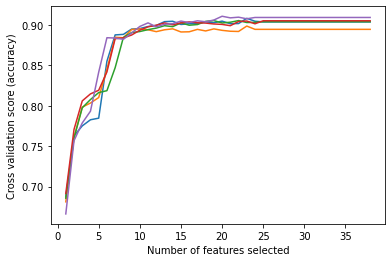

Num Features Before: 38
Num Features After: 23


In [3]:

min_features_to_select = 1

# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

# Recursively eliminate features with cross validation
rfecv = RFECV(estimator=clf_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, step=1, min_features_to_select= min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

X_new = rfecv.transform(X_train)
print("Num Features Before:", X_train.shape[1])
print("Num Features After:", X_new.shape[1])

In [11]:
rfecv.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True])

In [5]:
X_train_new = X_train.iloc[:, rfecv.support_]

In [6]:
X_train_new.columns

Index(['sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'dwell_time_1',
       'sd_1', 'mean_1', 'pwm_score', 'A_1', 'C_1', 'G_1', 'T_1', 'A_2', 'G_2',
       'A_3', 'A_6', 'C_6', 'T_6', 'A_7', 'C_7', 'G_7', 'T_7'],
      dtype='object')

In [7]:
clf_xgb.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=4266,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:

X_test_new = X_test.iloc[:, rfecv.support_]
X_val_new = X_val.iloc[:,rfecv.support_]

In [9]:
y_pred = clf_xgb.predict(X_val_new)
y_pred_proba = clf_xgb.predict_proba(X_val_new)
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
ap = average_precision_score(y_val, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.943502824858757
AUC-ROC: 0.8589077865436969
PR-ROC: 0.43660799994742344


In [10]:
y_pred = clf_xgb.predict(X_test_new)
y_pred_proba = clf_xgb.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.94539321104786
AUC-ROC: 0.8790505358203461
PR-ROC: 0.4149383216787601


In [ ]:
#TODO Finetune XGB model